In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Wed Apr  9 10:33:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             32W /   70W |    4168MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# CLIP ARCHITECTURE
!git clone https://github.com/openai/CLIP.git

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 256 (delta 126), reused 110 (delta 110), pack-reused 102 (from 1)
Receiving objects: 100% (256/256), 8.86 MiB | 9.60 MiB/s, done.
Resolving deltas: 100% (140/140), done.


In [ ]:
# TAMING_ TRANSFORMER ARCHITECTURE
!git clone https://github.com/CompVis/taming-transformers

fatal: destination path 'taming-transformers' already exists and is not an empty directory.


In [ ]:
# install some labrieries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip install torchtext --yes
!pip install einops


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --yes


In [ ]:
# import libraries
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# import pytorch library
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

In [ ]:
import yaml
from omegaconf import OmegaConf

from CLIP import clip

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# helper function

def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))


  plt.figure(figsize=(10,7))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

def norm_data(data):
  return (data.clip(-1,1)+1)/2   ## range between 0 and 1 in the results


# parameter
learning_rate = .5
batch_size = 1
wd = .1
noise_factor = .22


In [ ]:
# clip model
clipmodel,_ = clip.load("ViT-B/32", jit=False)
clipmodel.eval()
print(clip.available_models())

print("clip model visual input resolution :", clipmodel.visual.input_resolution)

device = torch.device("cuda:0")
torch.cuda.empty_cache()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
clip model visual input resolution : 224


In [ ]:
import os

# Change directory to taming-transformers
%cd /content/taming-transformers

# Create directories for storing model files
!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

# Download checkpoint and configuration files if not already present
if len(os.listdir("models/vqgan_imagenet_f16_16384/checkpoints/")) == 0:
    !wget -O models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt "https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1"
    !wget -O models/vqgan_imagenet_f16_16384/configs/model.yaml "https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1"

print("Setup completed!")


/content/taming-transformers
Setup completed!


In [ ]:
!pip install scikit-learn


In [ ]:


!pip install torch torchvision numpy


In [ ]:
import sys
sys.path.append("/path/to/taming-transformers")


In [ ]:
!git clone https://github.com/CompVis/taming-transformers.git


fatal: destination path 'taming-transformers' already exists and is not an empty directory.


In [ ]:
torch_inf = torch.inf
!sed -i 's/torch.tensor(np.Inf)/torch.inf/g' /usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/early_stopping.py

from taming.models.vqgan import VQModel

import torch
from taming.models.vqgan import VQModel
from pytorch_lightning.callbacks import ModelCheckpoint

def load_config(config_path, display = False):
   config_data = OmegaConf.load(config_path)
   if display:
     print(yaml.dump(OmegaConf.to_container(config_data)))
   return config_data

def load_vqgan(config, chk_path=None):
    model = VQModel(**config.model.params)
    if chk_path is not None:
        state_dict = torch.load(chk_path, map_location="cpu", weights_only=False)["state_dict"]
        model.load_state_dict(state_dict, strict=False)
    return model.eval()

def generator(x):
  x= taming_model.post_quant_conv(x)
  x= taming_model.decoder(x)
  return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config,chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [ ]:
# declare the values that we are going to optimize

class Parameters(torch.nn.Module):
  def _init_(self):
    super(Parameters, self).__init__()
    self.data = .5*torch.randn(batch_size, 256, size1//16, size2//16).cuda()

    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

def init_params():
  params = Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data],'lr' : learning_rate}], weight_decay = wd)
  return params, optimizer

torch.Size([1, 256, 16, 16])
img dimensions: torch.Size([1, 3, 256, 256])


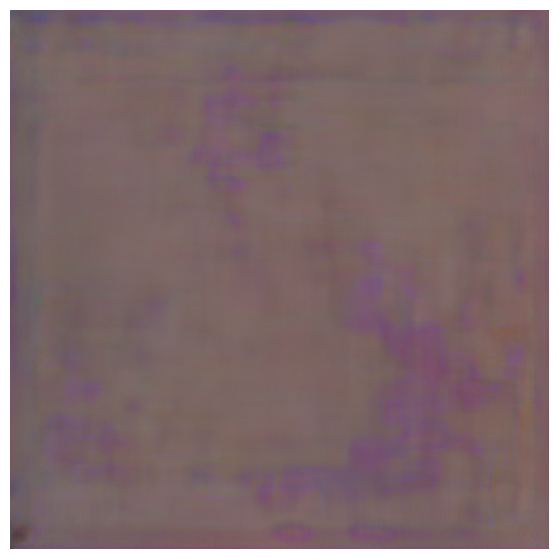

In [ ]:
# encoding prompts and a few more things
import torchvision

normalize = torchvision.transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])


def encodeText(text):
  t=clip.tokenize(text).cuda()
  t=clipmodel.encode_text(t).detach().clone()
  return t

def createEncodings(include,exclude,extras):
  include_enc=[]
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc=encodeText(exclude) if exclude != '' else 0
  extras_enc= encodeText(extras) if extras !='' else 0

  return include_enc, exclude_enc, extras_enc

import torchvision

augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2,.2), fill=0)
).cuda()

def init_params(z_shape=(1, 256, 16, 16), device="cuda"):
    # z_shape: (batch, channels, height, width) - shape from VQGAN latent space
    z = torch.randn(z_shape, device=device, requires_grad=True)
    z = torch.nn.Parameter(z)
    optimizer = torch.optim.Adam([z], lr=0.05)
    return z, optimizer


Params, optimizer = init_params()

print(Params.shape)
img = norm_data(generator(Params).cpu())
print("img dimensions:", img.shape)
show_from_tensor(img[0])




In [ ]:
 # create crops

def create_crops(img, num_crops=32,size1=64):
  p=size1 //2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0)

  img = augTransform(img)

  crop_set =[]
  for ch in range(num_crops):
    gap1 = int(torch.normal(1.2, .3,()).clip(.43, 1.9) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())

    crop = img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1]

    crop = torch.nn.functional.interpolate(crop, (244,244), mode='bilinear',align_corners=True)
    crop_set.append(crop)

  img_crops = torch.cat(crop_set,0)

  randnormal = torch.randn_like(img_crops, requires_grad=False)
  num_rands=0
  randstotal=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  for ns in range(num_rands):
    randstotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  img_crops = img_crops + noise_factor*randstotal*randnormal

  return img_crops


In [ ]:
# show current state of generation

def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params)

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float()
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen=norm_data(generated.cpu())
    show_from_tensor(latest_gen[0])

  return(latest_gen[0])

In [ ]:
 # opimization process

def optimize_result(Params,prompt):
  alpha=1
  beta=.5

  # image encoding
  out = generator(Params)
  out = norm_data(out)
  out = create_crops(out)
  out = normalize(out)
  image_enc=clipmodel.encode_image(out)

  # text encoding w1 and w2
  final_enc = w1*prompt + w1*extras_enc
  final_text_include_enc = final_enc / final_enc.norm(dim=-1,keepdim=True)
  final_text_exclude_enc = exclude_enc

  # calculation the loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1)
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1)

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

def optimize(Params,optimizer,prompt):
  loss = optimize_result(Params,prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
# training loop

def training_loop(Params, optimizer, show_crop=False):
  res_z=[]
  res_img=[]

  for prompt in include_enc:
    iteration= 0

    for it in range(total_iter):

      loss = optimize(Params, optimizer, prompt)

      if iteration >= 80 and iteration%show_step == 0:
        new_img = showme(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params.data)
        print("loss:", loss.item(), "\niteration:", iteration)

      iteration += 1
    torch.cuda.empty_cache()

  return res_img, res_z



Augmented cropped example


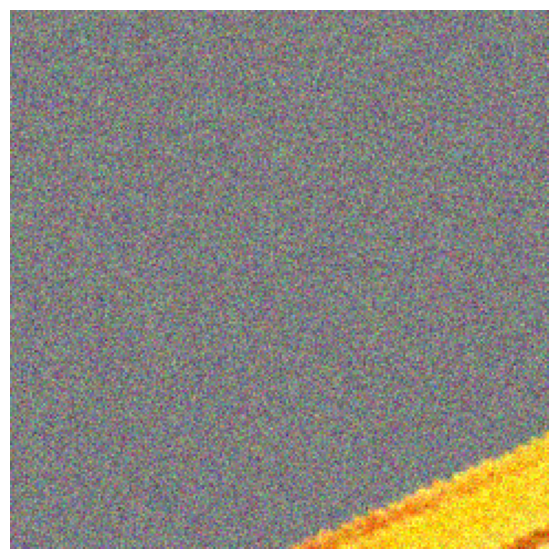

Generation


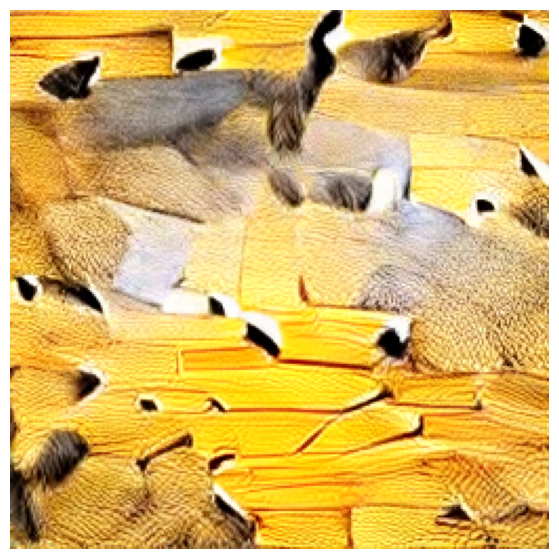

loss: -0.151611328125 
iteration: 80
Augmented cropped example


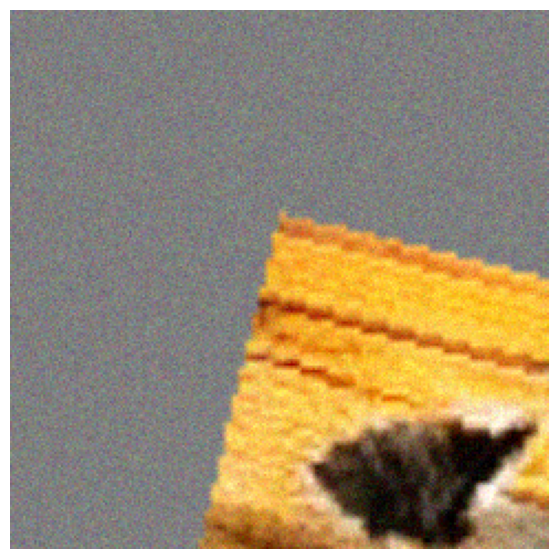

Generation


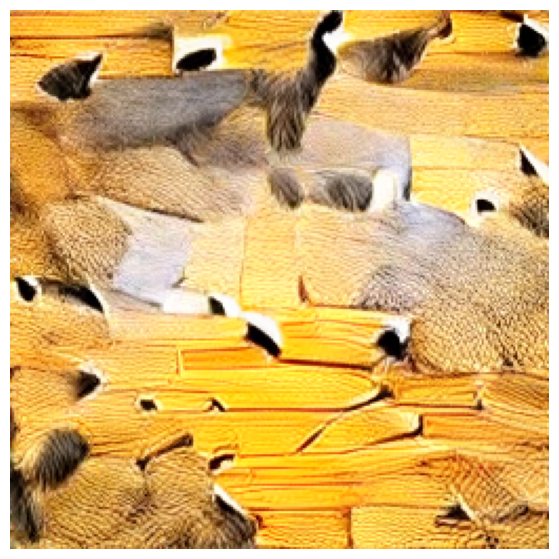

loss: -0.146728515625 
iteration: 90
Augmented cropped example


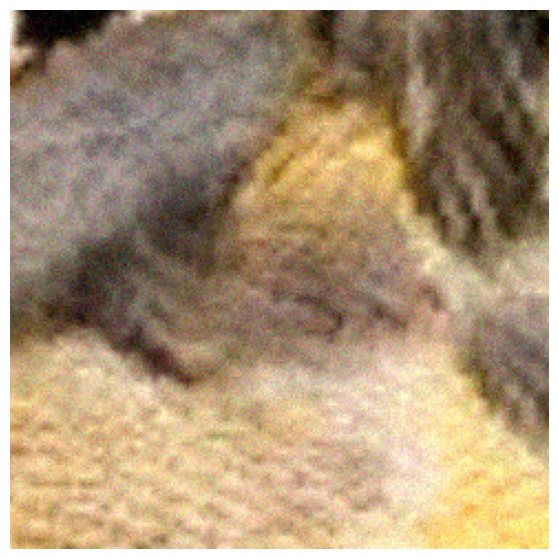

Generation


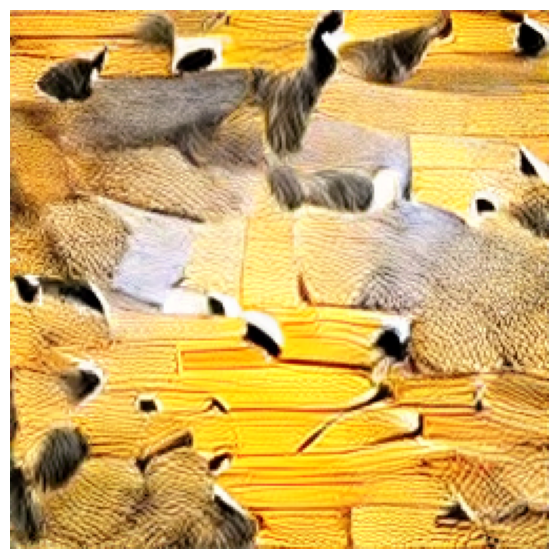

loss: -0.1495361328125 
iteration: 100


In [ ]:
torch.cuda.empty_cache()
include=[" cat "]
exclude = 'watermark'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=10
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z = training_loop(Params, optimizer, show_crop=True)
